# Import necessary modules

In [1]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu

2025-09-25 07:04:36.402533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758783876.670103      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758783876.746298      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Setting the input and output directory
INPUT_DIR = '/kaggle/input/flickr8k'
OUTPUT_DIR = '/kaggle/working'

In [3]:
# We are going to use pretraind vgg model
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

I0000 00:00:1758726867.986298      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758726867.987311      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1758726879.540698      97 service.cc:148] XLA service 0x7b630c004710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758726879.541532      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758726879.541553      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758726879.689463      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758726882.283275      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

# Loading Caption Data

In [6]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

In [7]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [8]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


# Preprocessing Captions: Getting Them Ready

Before we dive into the exciting world of creating captions for images, we need to prepare our captions so that our models can understand them. This process is known as preprocessing.

In [9]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [10]:
# before preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [11]:
# preprocess the text
clean(image_to_captions_mapping)

In [12]:
# after preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['startseq black dog carries green toy in his mouth as he walks through the grass endseq',
 'startseq black dog carrying something through the grass endseq',
 'startseq black dog has blue toy in its mouth endseq',
 'startseq dog in grass with blue item in his mouth endseq',
 'startseq wet black dog is carrying green toy through the grass endseq']

In [13]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [14]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [15]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [16]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [17]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


# Train Test Split

In [18]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.78)
train = image_ids[:split]
test = image_ids[split:]

In [19]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0

    while True:
        for image_id in data_keys:
            captions = image_to_captions_mapping[image_id]

            for caption in captions:
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1_batch.append(features[image_id][0])   # Image features
                    X2_batch.append(in_seq)                 # Input sequence
                    y_batch.append(out_seq)                 # Output sequence

                    batch_count += 1

                    if batch_count == batch_size:
                        X1_batch = np.array(X1_batch)
                        X2_batch = np.array(X2_batch)
                        y_batch = np.array(y_batch)

                        # ✅ yield tuple instead of list
                        yield (X1_batch, X2_batch), y_batch  

                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0


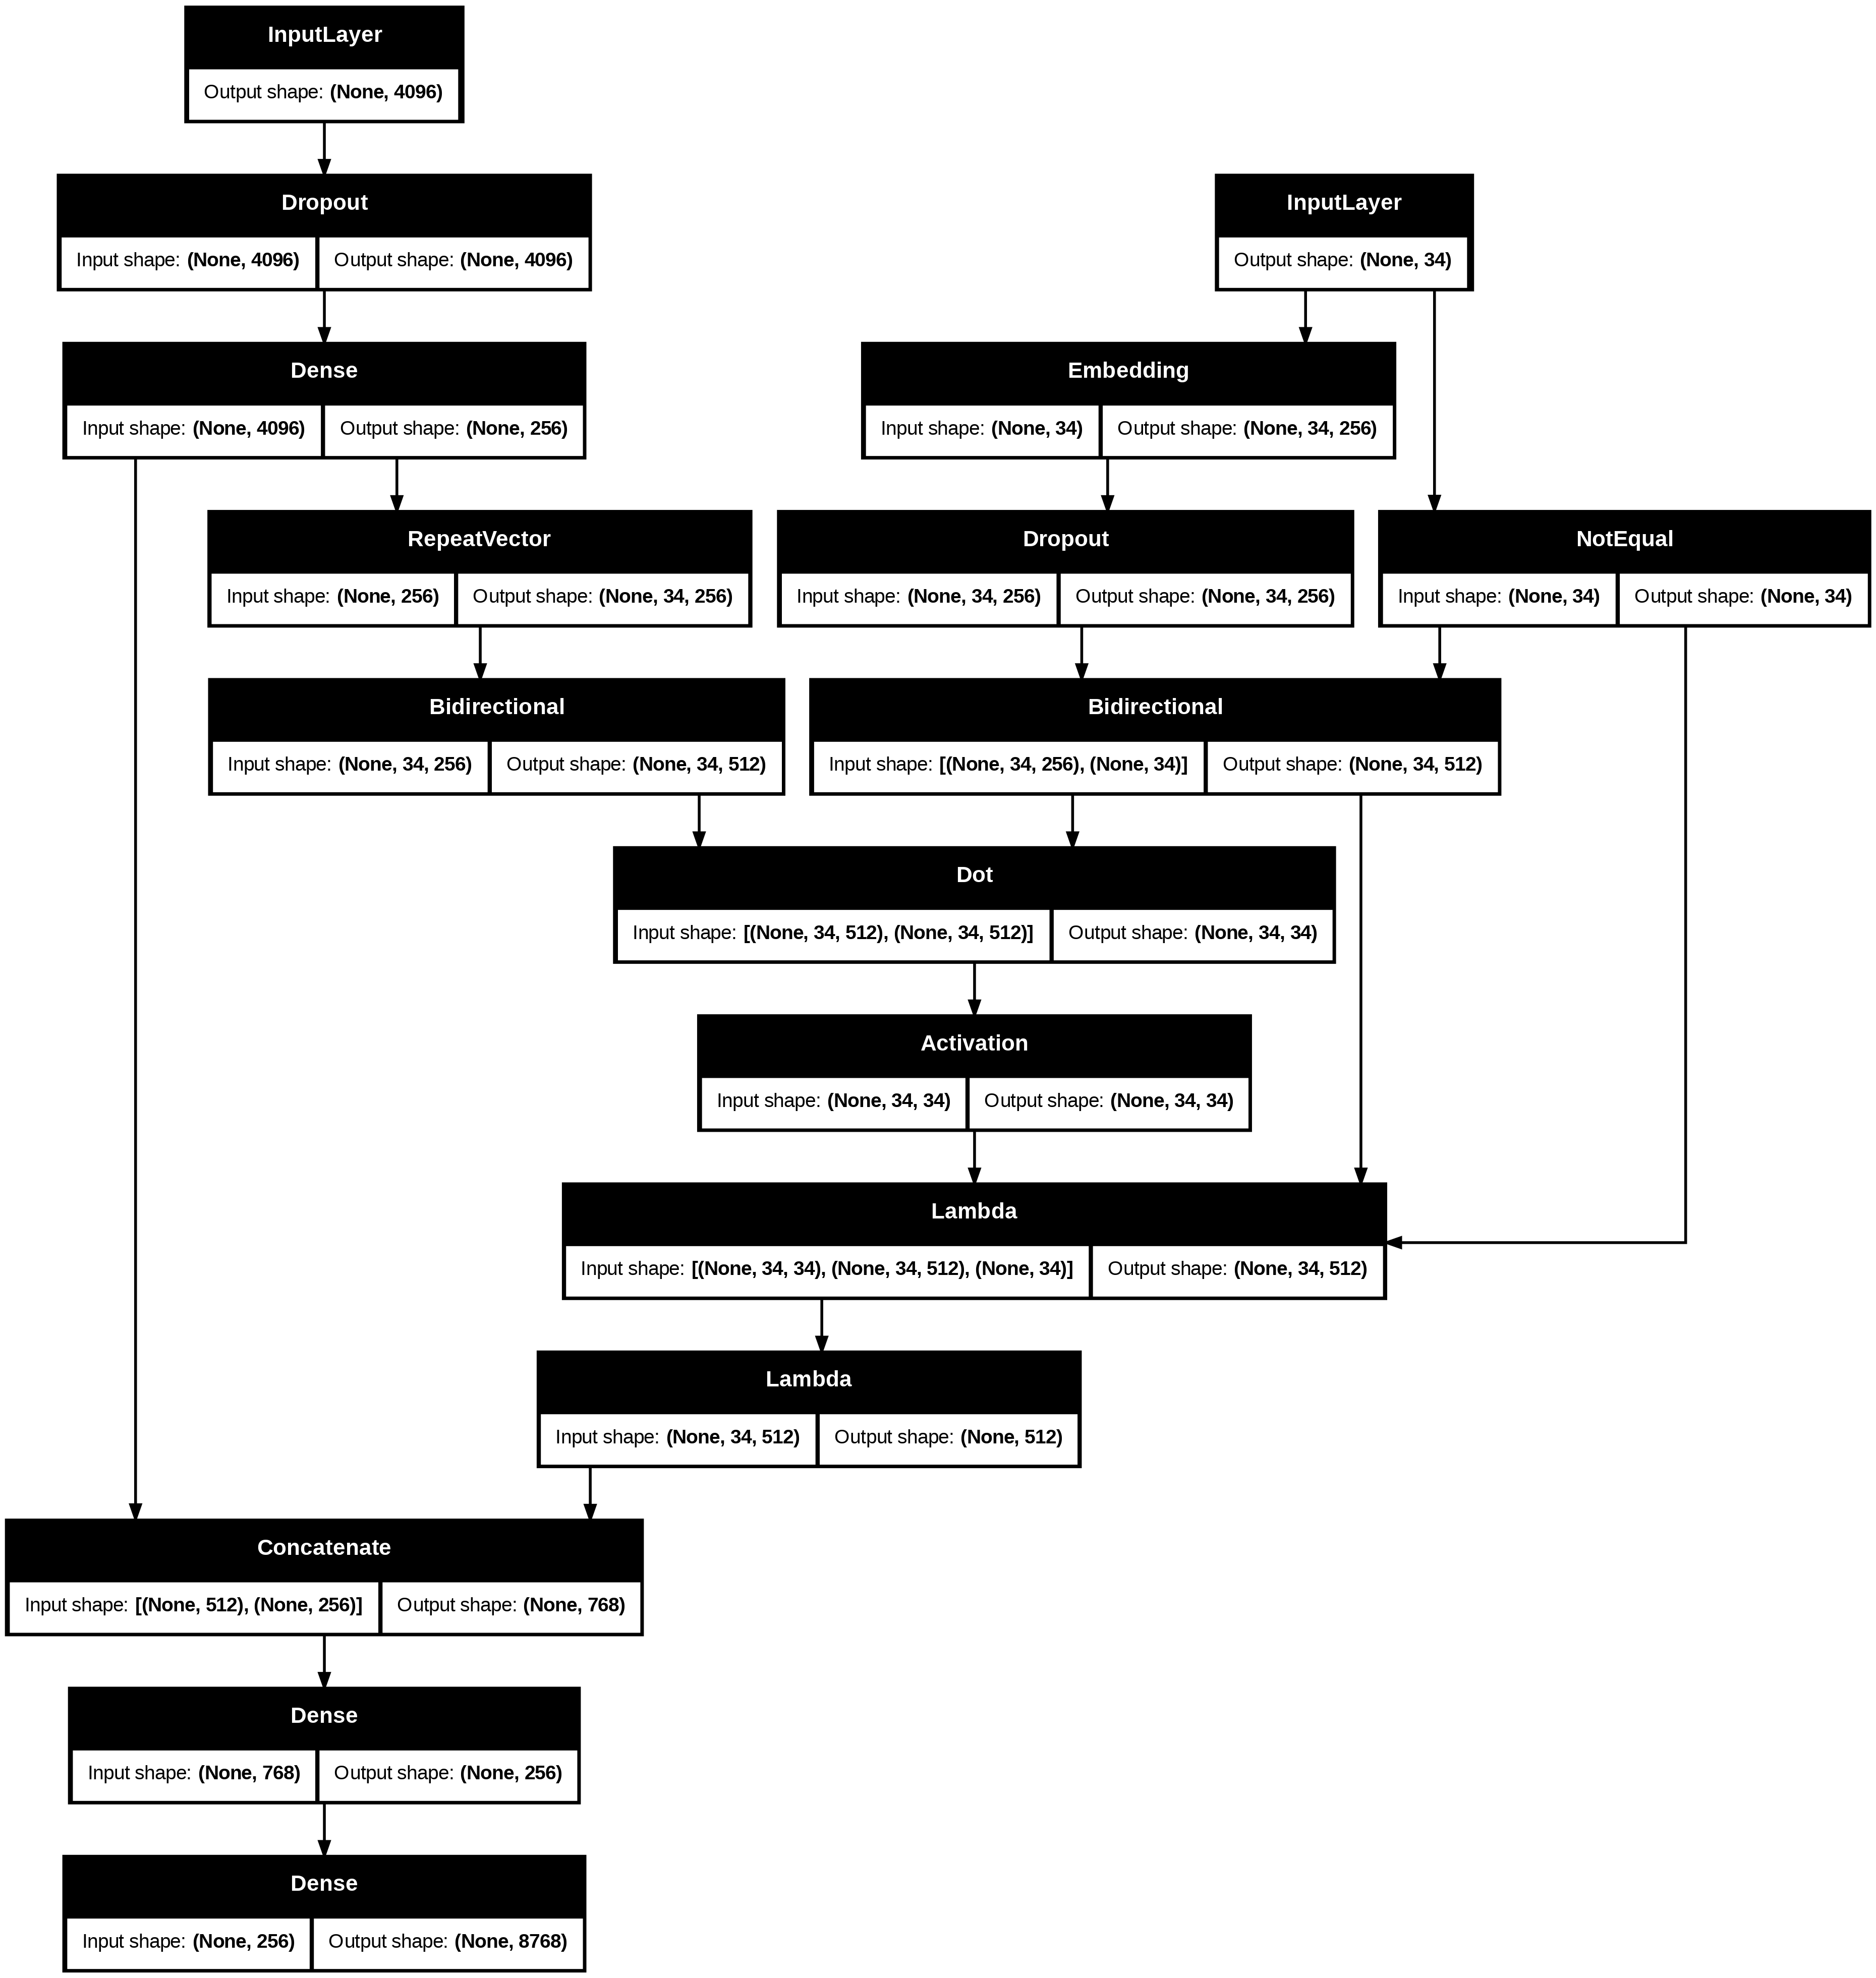

In [20]:
from keras.layers import Input, Dropout, Dense, RepeatVector, Bidirectional, LSTM
from keras.layers import Embedding, Dot, Activation, Lambda, concatenate
from keras.models import Model
from keras.utils import plot_model
import tensorflow as tf

# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings (weighted sum using einsum)
attention_context = Lambda(
    lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1])
)([attention_scores, se3])

# ✅ FIX: Use Lambda instead of raw tf.reduce_sum
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_context)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True, to_file='model.png')


In [21]:
# Set the number of epochs, batch size
epochs = 50
batch_size = 32

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Dictionary to store history
history_all = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    # Train for 1 epoch
    history = model.fit(
        train_generator, 
        epochs=1, 
        steps_per_epoch=steps_per_epoch,
        validation_data=test_generator, 
        validation_steps=validation_steps,
        verbose=1
    )
    
    # Append results to history_all
    history_all['loss'] += history.history['loss']
    history_all['val_loss'] += history.history['val_loss']
    if 'accuracy' in history.history:  # check if model tracks accuracy
        history_all['accuracy'] += history.history['accuracy']
        history_all['val_accuracy'] += history.history['val_accuracy']


Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 6.9570 - val_loss: 6.2881
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 5.1617 - val_loss: 6.2499
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 4.8154 - val_loss: 6.2746
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 4.3692 - val_loss: 6.9376
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 4.1273 - val_loss: 6.6325
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.8711 - val_loss: 6.8787
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.5572 - val_loss: 7.2552
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.2627 - val_loss: 6.9877
Epoch 9/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.0338 - val_loss: 7.6051
Epoch 10/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.9555 - val_loss: 7.2670
Epoch 11/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.6804 - val_loss: 7.1788
Epoch 12/50
198/198 ━━━━━━━━━━━━━━━━━━━━

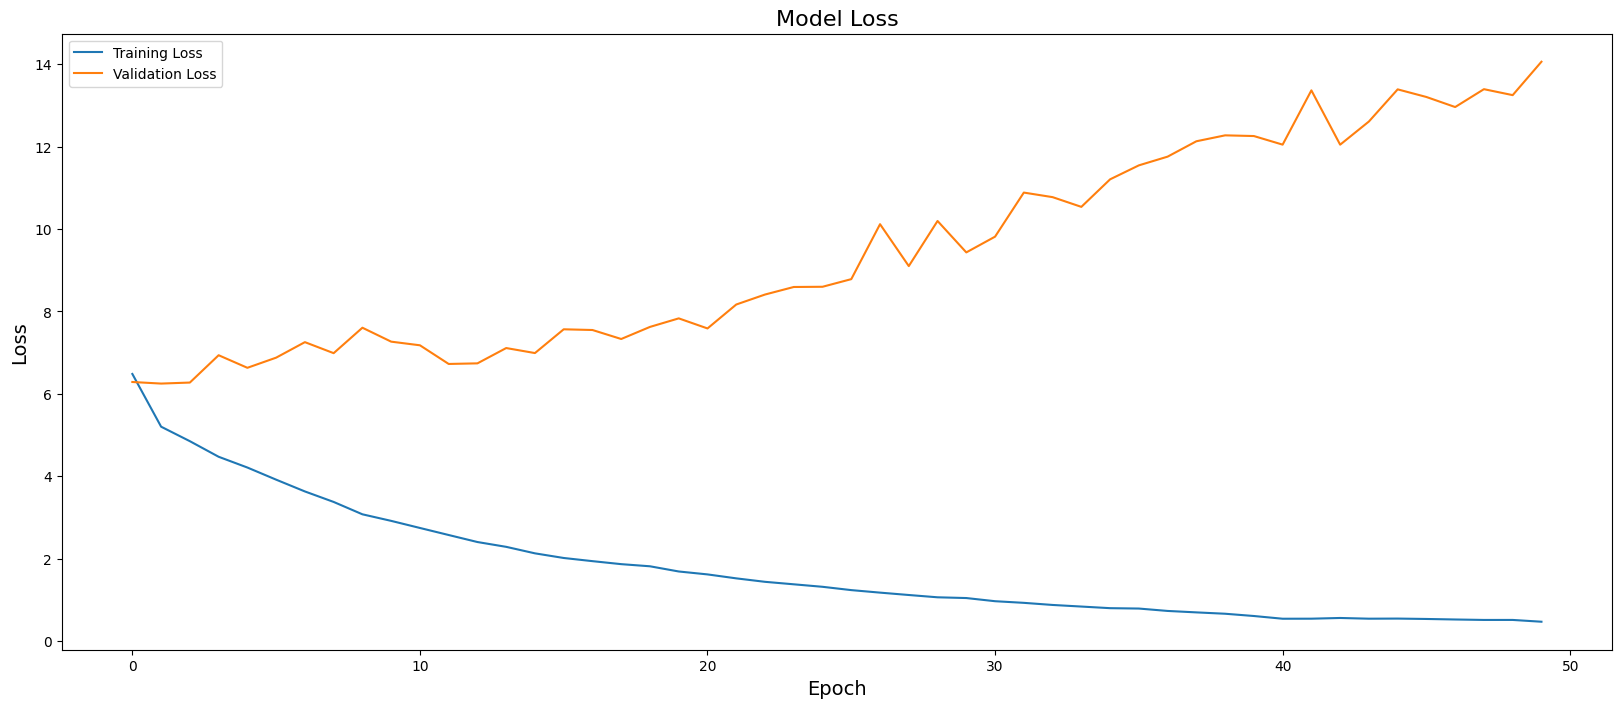

In [22]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(20,8))
plt.plot(history_all['loss'], label='Training Loss')
plt.plot(history_all['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.show()

# Plot Accuracy (only if you compiled with metrics=['accuracy'])
if history_all['accuracy']:
    plt.figure(figsize=(20,8))
    plt.plot(history_all['accuracy'], label='Training Accuracy')
    plt.plot(history_all['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    plt.show()


In [23]:
# Save the model
model.save(OUTPUT_DIR+'/mymodel.h5')

# Captions Generation

In [24]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [25]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'
    
    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        
        # Append the predicted word to the caption
        caption += " " + predicted_word
        
        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import numpy as np

# Function to predict caption
def predict_caption(model, image_features, tokenizer, max_caption_length):
    in_text = 'startseq'
    
    for i in range(max_caption_length):
        # Convert current text to sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Right-pad the sequence (padding='post') for cuDNN compatibility
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')
        
        # Predict next word
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the word with highest probability
        predicted_index = np.argmax(yhat)
        word = tokenizer.index_word.get(predicted_index, None)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    
    return in_text

# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    actual_captions = image_to_captions_mapping[key]
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    
    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()
    
    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))


100%|██████████| 1781/1781 [26:07<00:00,  1.14it/s]


BLEU-1: 0.417431
BLEU-2: 0.183436


# Predicting captions for Images

In [27]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
--------------------Predicted--------------------
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq


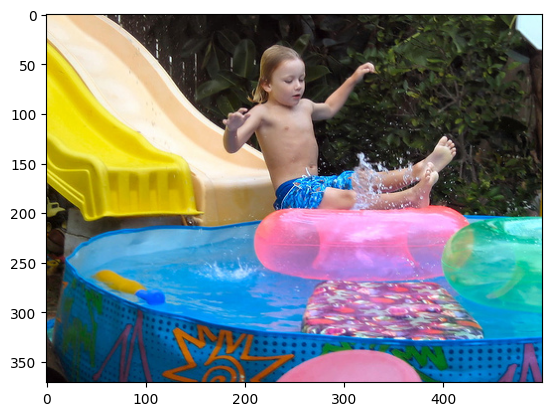

In [28]:
generate_caption("1077546505_a4f6c4daa9.jpg")

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man stands in front of skyscraper endseq


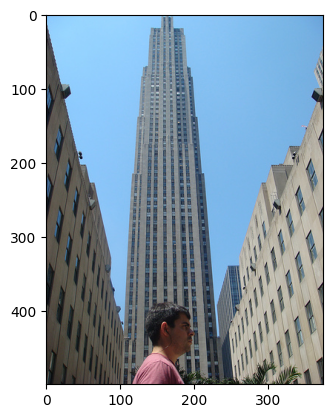

In [31]:
generate_caption("1032460886_4a598ed535.jpg")

In [32]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.1 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.8 MB/s eta 0:00:00:00:0100:01


In [34]:
# import streamlit as st
# import numpy as np
# import pickle
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.saving import register_keras_serializable

# # ---------------------------
# # Register custom layers
# # ---------------------------
# @register_keras_serializable()
# class NotEqual(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(NotEqual, self).__init__(**kwargs)
#     def call(self, inputs):
#         return tf.not_equal(inputs[0], inputs[1])

# # ---------------------------
# # Load feature extractor
# # ---------------------------
# mobilenet_model = MobileNetV2(weights="imagenet")
# mobilenet_model = Model(inputs=mobilenet_model.inputs, outputs=mobilenet_model.layers[-2].output)

# # ---------------------------
# # Load captioning model
# # ---------------------------
# model_path = "/kaggle/input/mymodel.h5/tensorflow2/default/1/mymodel.h5"
# tokenizer_path = "/kaggle/input/mymodel.h5/tokenizer.pkl"

# # Register LSTM and Bidirectional layers to avoid "Could not locate class 'LSTM'" errors
# custom_objects = {
#     'NotEqual': NotEqual,
#     'LSTM': tf.keras.layers.LSTM,
#     'Bidirectional': tf.keras.layers.Bidirectional
# }

# model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# # ---------------------------
# # Load tokenizer
# # ---------------------------
# with open(tokenizer_path, 'rb') as f:
#     tokenizer = pickle.load(f)

# max_caption_length = 34

# # ---------------------------
# # Caption generation functions
# # ---------------------------
# def get_word_from_index(index, tokenizer):
#     return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

# def predict_caption(model, image_features, tokenizer, max_caption_length):
#     caption = "startseq"
#     for _ in range(max_caption_length):
#         sequence = tokenizer.texts_to_sequences([caption])[0]
#         sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')
#         yhat = model.predict([image_features, sequence], verbose=0)
#         predicted_index = np.argmax(yhat)
#         predicted_word = get_word_from_index(predicted_index, tokenizer)
#         if predicted_word is None or predicted_word == "endseq":
#             break
#         caption += " " + predicted_word
#     return caption

# # ---------------------------
# # Streamlit UI
# # ---------------------------
# st.set_page_config(page_title="Caption Generator App", page_icon="📷")
# st.title("Image Caption Generator")
# st.markdown("Upload an image, and this app will generate a caption using a trained LSTM model.")

# uploaded_image = st.file_uploader("Choose an image", type=["jpg", "jpeg", "png"])

# if uploaded_image is not None:
#     st.subheader("Uploaded Image")
#     st.image(uploaded_image, caption="Uploaded Image", use_column_width=True)

#     st.subheader("Generated Caption")
#     with st.spinner("Generating caption..."):
#         image = load_img(uploaded_image, target_size=(224, 224))
#         image = img_to_array(image)
#         image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#         image = preprocess_input(image)

#         image_features = mobilenet_model.predict(image, verbose=0)
#         generated_caption = predict_caption(model, image_features, tokenizer, max_caption_length)
#         generated_caption = generated_caption.replace("startseq", "").replace("endseq", "").strip()

#     st.markdown(
#         f'<div style="border-left: 6px solid #ccc; padding: 5px 20px; margin-top: 20px;">'
#         f'<p style="font-style: italic;">“{generated_caption}”</p>'
#         f'</div>',
#         unsafe_allow_html=True
#     )


In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class NotEqual(Layer):
    def __init__(self, **kwargs):
        super(NotEqual, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        x1, x2 = inputs
        return tf.not_equal(x1, x2)

    def get_config(self):
        config = super(NotEqual, self).get_config()
        return config


In [52]:
# import gradio as gr
# from PIL import Image
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import pickle
# from tensorflow.keras.utils import custom_object_scope
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# from tensorflow.keras.preprocessing.image import img_to_array

# # Define custom NotEqual layer class
# class NotEqual(Layer):
#     def __init__(self, **kwargs):
#         super(NotEqual, self).__init__(**kwargs)

#     def call(self, inputs, **kwargs):
#     # Unpack inputs assuming inputs is a list or tuple of tensors
#     x1, x2 = inputs
#     return tf.not_equal(x1, x2)


#     def get_config(self):
#         config = super(NotEqual, self).get_config()
#         return config

# # Register custom layer
# custom_objects = {'NotEqual': NotEqual}

# # Load model with custom object
# with custom_object_scope(custom_objects):
#     model = tf.keras.models.load_model('mymodel.h5')

# # Load tokenizer
# with open('tokenizer.pkl', 'rb') as f:
#     tokenizer = pickle.load(f)

# max_caption_length = YOUR_MAX_CAPTION_LENGTH  # Replace with actual max caption length

# feature_extractor = VGG16()
# feature_extractor = tf.keras.Model(inputs=feature_extractor.inputs, outputs=feature_extractor.layers[-2].output)

# def extract_features(image: Image.Image):
#     image = image.resize((224, 224))
#     image = img_to_array(image)
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     image = preprocess_input(image)
#     features = feature_extractor.predict(image, verbose=0)
#     return features

# def get_word_from_index(index, tokenizer):
#     return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

# def predict_caption(image: Image.Image):
#     image_features = extract_features(image)
#     in_text = 'startseq'
#     for _ in range(max_caption_length):
#         sequence = tokenizer.texts_to_sequences([in_text])[0]
#         sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')
#         yhat = model.predict([image_features, sequence], verbose=0)
#         yhat = np.argmax(yhat)
#         word = get_word_from_index(yhat, tokenizer)
#         if word is None or word == 'endseq':
#             break
#         in_text += ' ' + word
#     caption = in_text.replace('startseq ', '').replace(' endseq', '')
#     return caption

# iface = gr.Interface(
#     fn=predict_caption,
#     inputs=gr.Image(type="pil"),
#     outputs=gr.Textbox(label="Generated Caption"),
#     title="Image Caption Generator",
#     description="Upload an image and get a generated caption using the trained model."
# )

# iface.launch()
